<a href="https://colab.research.google.com/github/whyeon92/ESAA_YB/blob/Code_Study/ESAA_HW0412.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📌 4-3. 앙상블 학습

In [1]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns = cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [8]:
#아래 결과에서 warning으로 결과보기가 어려워서 경고 무시 코드 작성했습니다.
import warnings
warnings.filterwarnings('ignore')

In [9]:
#개별 모델은 로지스틱 회귀와 KNN임
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors = 8)

#개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기
vo_clf = VotingClassifier(estimators = [('LR', lr_clf), ('KNN', knn_clf)], voting = 'soft')

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size = 0.2, random_state = 156)

#VotingClassifier 학습/예측/평가
vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

#개별 모델의 학습/예측/평가
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
  classifier.fit(X_train, y_train)
  pred = classifier.predict(X_test)
  class_name = classifier.__class__.__name__
  print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test, pred)))

Voting 분류기 정확도: 0.9474
LogisticRegression 정확도: 0.9386
KNeighborsClassifier 정확도: 0.9386


**[앙상블]**  
여러명이 모여서 결론을 내면 한 명이 낸 결론보다 더 낫다!  
라는 논리를 기반으로 생긴 기법이 바로 앙상블 학습.  
- 비정형 데이터의 분류는 딥러닝이 뛰어나지만 정형의 경우 앙상블이 대개 더 뛰어난 성능
- 배깅 -> 랜덤 포레스트
- 부스팅 -> GBM, XGBoost, LGBM...
- 보팅 -> 소프트, 하드


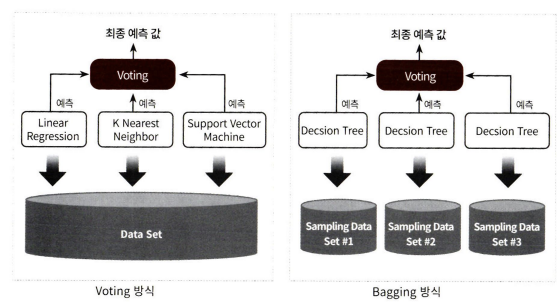

**[배깅]**  
Bootstrapping을 통해 복원 추출로 학습 데이터에서 여러 세트의 샘플 데이터 추출  
➡️ 각 샘플 데이터에 대해 개별 분류기 생성  
➡️ 개별 분류기의 결과로 보팅 진행, 최종 결과 도출  
  
**[부스팅]**  
샘플 데이터 생성 방법은 배깅과 같음.   
➡️ 앞에서 분류한 결과 중 틀린 결과에 가중치 부여  
➡️ 틀렸던 애들을 더 중요하게 판단, 오류 고쳐가며 분류  

   




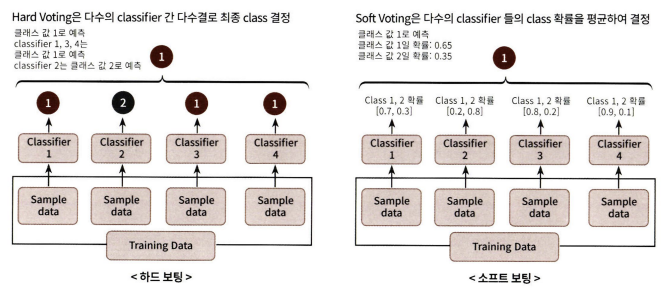

**[하드 보팅]**   
- 다수결 원칙
- 다수의 분류기가 결정한 예측값을 최종 보팅 결괏값으로 선정
  
**[소프트 보팅]**
- 분류기들의 레이블 값 결정 확률을 모두 더하고 이를 평균해서 이들 중 확률이 가장 높은 레이블 값을 최종 보팅 결괏값으로 선정  
- 보통 소프트 보팅이 더 많이 쓰임

# 📌 4-4. 랜덤 포레스트

In [10]:
#구글 코랩 환경 사용으로 드라이브 마운트 및 디렉터리 설정
from google.colab import drive
drive.mount('/content/gdrive/')

path = "/content/gdrive/My Drive/EuronData/"

Mounted at /content/gdrive/


In [11]:
def get_new_feature_name_df(old_feature_name_df):
  feature_dup_df = pd.DataFrame(data = old_feature_name_df.groupby('column_name').cumcount(), columns = ['dup_cnt'])
  feature_dup_df = feature_dup_df.reset_index()
  new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how = 'outer')
  new_feature_name_df['column_name'] = new_feature_name_df[['column_name',
                                                            'dup_cnt']].apply(lambda x : x[0] + '_' + str(x[1])
                                                            if x[1] > 0 else x[0], axis = 1)

  new_feature_name_df = new_feature_name_df.drop(['index'], axis = 1)
  return new_feature_name_df

In [12]:
def get_human_dataset():

  #각 데이터 파일은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당
  feature_name_df = pd.read_csv(path + 'human_activity/features.txt', sep = '\s+',
                                header = None, names = ['column_index', 'column_name'])

  #중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame 생성
  new_feature_name_df = get_new_feature_name_df(feature_name_df)

  #DataFrame에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
  feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

  #학습 피처 데이터 세트와 테스트 피처 데이터를 DataFrame으로 로딩하고 칼럼명은 feature_name으로 적용
  X_train = pd.read_csv(path + 'human_activity/train/X_train.txt', sep = '\s+', header = None, names = feature_name)
  X_test = pd.read_csv(path + 'human_activity/test/X_test.txt', sep = '\s+', header = None, names = feature_name)

  #학습 레이블과 테스트 레이블 데이터를 DataFrame으로 로딩하고 칼럼명은 action으로 부여
  y_train = pd.read_csv(path + 'human_activity/train/y_train.txt', sep = '\s+', header = None, names = ['action'])
  y_test = pd.read_csv(path + 'human_activity/test/y_test.txt', sep = '\s+', header = None, names = ['action'])

  #로드된 학습/테스트용 DataFrame을 모두 반환
  return X_train, X_test, y_train, y_test

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

#결정 트리에서 사용한 get_human_dataset()을 이용해 학습/테스트용 데이터프레임 변환
X_train, X_test, y_train, y_test = get_human_dataset()

#랜덤 포레스트 학습 및 별도의 테스트 세트로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state = 0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9253


In [14]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100],
    'max_depth': [6, 8, 10, 12],
    'min_samples_leaf':[8, 12, 18],
    'min_samples_split': [8, 16, 20]
}
#RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 2, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9180


In [16]:
rf_clf1 = RandomForestClassifier(n_estimators = 300, max_depth= 10, min_samples_leaf= 8, min_samples_split = 8, random_state = 0)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

예측 정확도: 0.9165


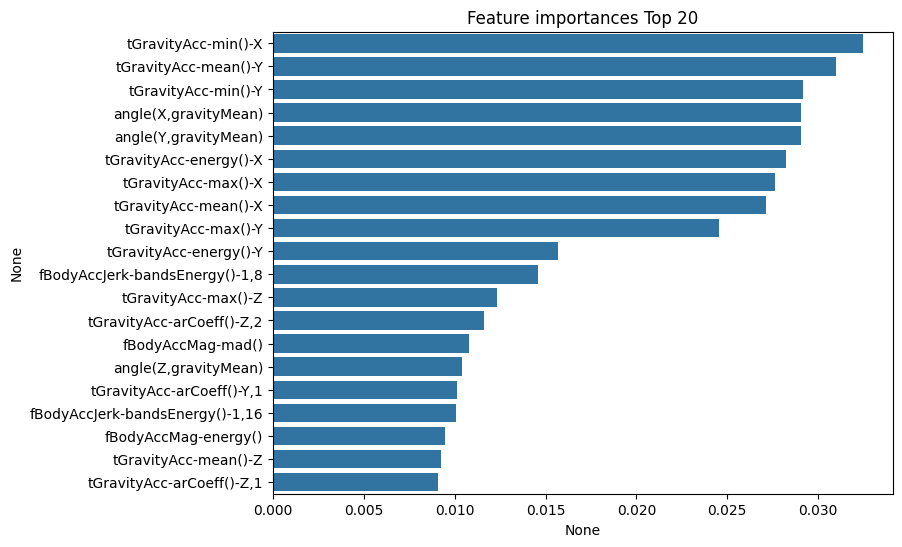

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending = False)[:20]

plt.figure(figsize = (8, 6))
plt.title('Feature importances Top 20')
sns.barplot(x = ftr_top20, y=ftr_top20.index)
plt.show()

**[랜덤 포레스트]**
- 배깅계열 알고리즘의 대표 주자  
- 앙상블 중 비교적 빠른 수행 속도
- 높은 예측 성능
- 부트 스트래핑으로 데이터 세트 분할, 샘플 데이터 생성
- `RandomForest()`
 - `n_estimators`: 결정 트리의 개수
 - `max_features`: 결정 트리에서의 파라미터와 동일
 - `max_depth`, `min_samples_leaf`: 결정트리에서처럼 과적합 제어용

# 📌 4-5. GBM

In [20]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

#GBM 수행 시간 측정을 위함. 시작 시간 설정
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state = 0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print('GBM 수행 시간: {0:.1f}초'.format(time.time() - start_time))

GBM 정확도: 0.9393
GBM 수행 시간: 1015.8초


In [23]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators' : [100, 500],
    'learning_rate' : [0.05, 0.1]
}
grid_cv = GridSearchCV(gb_clf, param_grid = params, cv = 2, verbose = 1, n_jobs = -1)
grid_cv.fit(X_train, y_train)
print('최적 하이퍼 파라미터 : \n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

Fitting 2 folds for each of 4 candidates, totalling 8 fits
최적 하이퍼 파라미터 : 
 {'learning_rate': 0.05, 'n_estimators': 500}
최고 예측 정확도: 0.9002


In [24]:
#GridSearchCV를 이용해 최적으로 학습된 estimator로 예측 수행
gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))

GBM 정확도: 0.9393


**[GBM]**  
- 배깅 아니고 부스팅 계열의 기본. 에이다 부스트의 구현 과정을 살펴보면서 부스팅 이해 가능.  
- 한마디로 **오류를 줄이기 위해서 잘못 분류한 값에 대해 가중치를 더 부여하면서 오류 값을 잡아나가는 프로세스**  
- GBM은 오류식(손실)을 최소화하는 방향성을 가지고 가중치 값을 업데이트 하는 경사 하강법을 이용해 만듦.
- `GradientBoostingClassifier()`
 - `loss`: 경사하강법의 비용함수 지정
 - `learning_rate`: 학습률 지정, 얼마나 많이 오류값을 보정할 것인지.
 - `n_estimators`: weak learner 개수
 - `subsample`: weak learner가 학습에 사용하는 데이터의 샘플링 비율

# 📌 4-6. XGBoost

구글 코랩 사용으로 설치 과정 생략

In [25]:
import xgboost as xgb
from xgboost import XGBClassifier

In [26]:
import xgboost
print(xgboost.__version__)

2.0.3


## 파이썬 래퍼 XGBoost

In [27]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target
cancer_df = pd.DataFrame(data = X_features, columns = dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [28]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
target
1    357
0    212
Name: count, dtype: int64


In [29]:
#전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size = 0.2, random_state = 156)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


In [30]:
dtrain = xgb.DMatrix(data = X_train, label = y_train)
dtest = xgb.DMatrix(data = X_test, label = y_test)

In [31]:
params = {'max_depth':3,
          'eta' : 0.1,
          'objective' : 'binary:logistic',
          'eval_metirc':'logloss',
          'early_stopping' : 100}

num_rounds = 400

In [32]:
#train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval'로 명기합니다
wlist = [(dtrain, 'train'), (dtest, 'eval')]
#하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain = dtrain, num_boost_round = num_rounds, early_stopping_rounds = 100, evals = wlist)

[0]	train-logloss:0.58431	eval-logloss:0.56554
[1]	train-logloss:0.51885	eval-logloss:0.50669
[2]	train-logloss:0.46457	eval-logloss:0.45868
[3]	train-logloss:0.41713	eval-logloss:0.41822
[4]	train-logloss:0.37585	eval-logloss:0.38103
[5]	train-logloss:0.34075	eval-logloss:0.35137
[6]	train-logloss:0.31028	eval-logloss:0.32588
[7]	train-logloss:0.28283	eval-logloss:0.30127
[8]	train-logloss:0.25925	eval-logloss:0.28197
[9]	train-logloss:0.23822	eval-logloss:0.26265
[10]	train-logloss:0.21951	eval-logloss:0.24821
[11]	train-logloss:0.20251	eval-logloss:0.23231
[12]	train-logloss:0.18759	eval-logloss:0.22079
[13]	train-logloss:0.17386	eval-logloss:0.20795
[14]	train-logloss:0.16199	eval-logloss:0.19764
[15]	train-logloss:0.15109	eval-logloss:0.18950
[16]	train-logloss:0.14056	eval-logloss:0.18052
[17]	train-logloss:0.13137	eval-logloss:0.17246
[18]	train-logloss:0.12329	eval-logloss:0.16512
[19]	train-logloss:0.11565	eval-logloss:0.15828
[20]	train-logloss:0.10860	eval-logloss:0.15436
[2

In [33]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10], 3))

#예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [1 if x>0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨
[0.904 0.004 0.908 0.267 0.992 1.    1.    0.999 0.994 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
#지난 과제에서 정의한 get_clf_eval 불러오기
def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  #ROC-AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차행렬')
  print(confusion)
  #ROC-AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [35]:
get_clf_eval(y_test, preds, pred_probs)

오차행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870, F1: 0.9744, AUC: 0.9951


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

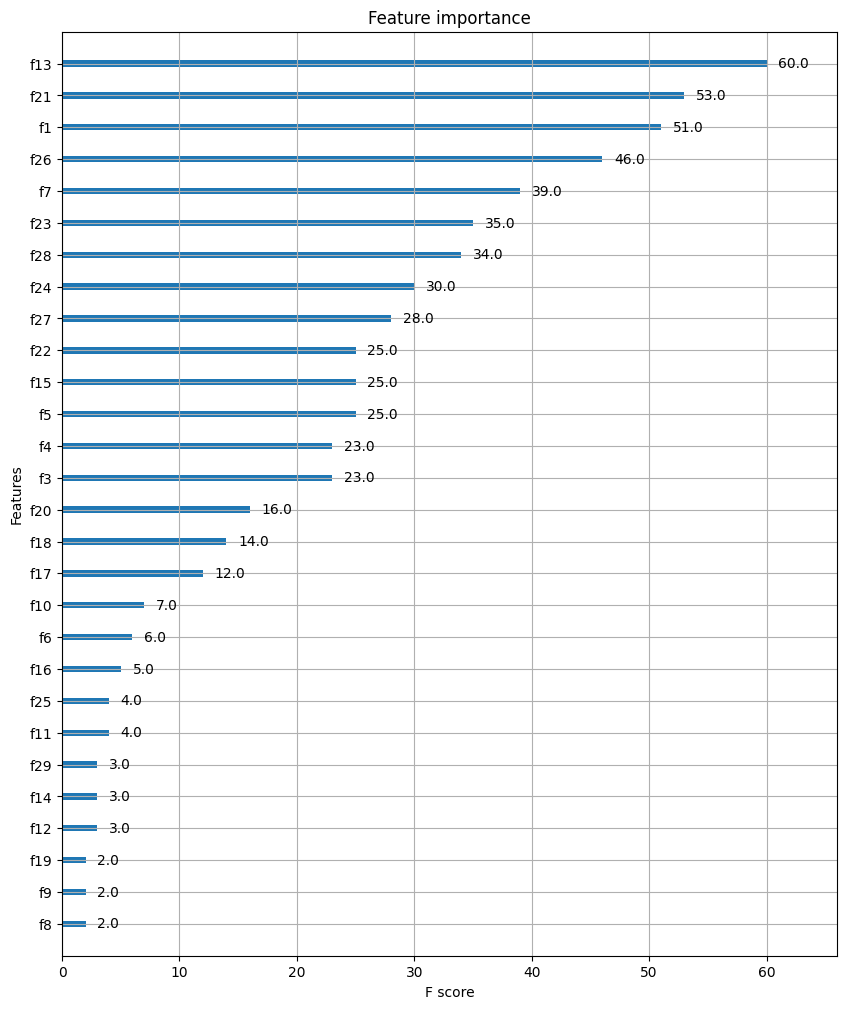

In [36]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (10, 12))
plot_importance(xgb_model, ax=ax)

In [37]:
xgboost.cv(params, dtrain, num_boost_round = 10, nfold = 3, stratified = False, folds = None, metrics = (), obj = None, feval = None, maximize =False, early_stopping_rounds = None, fpreproc = None, as_pandas = True,
          verbose_eval = None, show_stdv = True, seed = 0, callbacks = None, shuffle = True)

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.584737,0.005961,0.592041,0.008024
1,0.517898,0.004745,0.532735,0.007335
2,0.462199,0.003589,0.483123,0.008418
3,0.415639,0.003043,0.441435,0.011510
4,0.375350,0.002036,0.406194,0.014400
5,0.340102,0.000854,0.373831,0.015171
6,0.308902,0.000900,0.348411,0.018183
7,0.281927,0.001335,0.324136,0.017817
8,0.257775,0.001182,0.304679,0.021239
9,0.236439,0.001313,0.286202,0.021203


## 사이킷런 래퍼 XGBoost

In [38]:
#사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBRFClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth = 3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [39]:
get_clf_eval(y_test, w_preds, w_pred_proba)

오차행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870, F1: 0.9806, AUC: 0.9947


In [40]:
from xgboost import XGBRFClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth = 3)
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = 'logloss', eval_set = evals, verbose = True)
ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.56554
[1]	validation_0-logloss:0.50669
[2]	validation_0-logloss:0.45868
[3]	validation_0-logloss:0.41822
[4]	validation_0-logloss:0.38103
[5]	validation_0-logloss:0.35137
[6]	validation_0-logloss:0.32588
[7]	validation_0-logloss:0.30127
[8]	validation_0-logloss:0.28197
[9]	validation_0-logloss:0.26265
[10]	validation_0-logloss:0.24821
[11]	validation_0-logloss:0.23231
[12]	validation_0-logloss:0.22079
[13]	validation_0-logloss:0.20795
[14]	validation_0-logloss:0.19764
[15]	validation_0-logloss:0.18950
[16]	validation_0-logloss:0.18052
[17]	validation_0-logloss:0.17246
[18]	validation_0-logloss:0.16512
[19]	validation_0-logloss:0.15828
[20]	validation_0-logloss:0.15436
[21]	validation_0-logloss:0.14633
[22]	validation_0-logloss:0.13936
[23]	validation_0-logloss:0.13393
[24]	validation_0-logloss:0.13015
[25]	validation_0-logloss:0.12489
[26]	validation_0-logloss:0.12206
[27]	validation_0-logloss:0.11890
[28]	validation_0-logloss:0.11637
[29]	validation_0-loglos

In [41]:
get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

오차행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870, F1: 0.9744, AUC: 0.9951


In [42]:
#early_stopping_rounds를 10으로 설정하고 재 학습
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds = 10, eval_metric = 'logloss', eval_set = evals, verbose = True)
ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.56554
[1]	validation_0-logloss:0.50669
[2]	validation_0-logloss:0.45868
[3]	validation_0-logloss:0.41822
[4]	validation_0-logloss:0.38103
[5]	validation_0-logloss:0.35137
[6]	validation_0-logloss:0.32588
[7]	validation_0-logloss:0.30127
[8]	validation_0-logloss:0.28197
[9]	validation_0-logloss:0.26265
[10]	validation_0-logloss:0.24821
[11]	validation_0-logloss:0.23231
[12]	validation_0-logloss:0.22079
[13]	validation_0-logloss:0.20795
[14]	validation_0-logloss:0.19764
[15]	validation_0-logloss:0.18950
[16]	validation_0-logloss:0.18052
[17]	validation_0-logloss:0.17246
[18]	validation_0-logloss:0.16512
[19]	validation_0-logloss:0.15828
[20]	validation_0-logloss:0.15436
[21]	validation_0-logloss:0.14633
[22]	validation_0-logloss:0.13936
[23]	validation_0-logloss:0.13393
[24]	validation_0-logloss:0.13015
[25]	validation_0-logloss:0.12489
[26]	validation_0-logloss:0.12206
[27]	validation_0-logloss:0.11890
[28]	validation_0-logloss:0.11637
[29]	validation_0-loglos

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

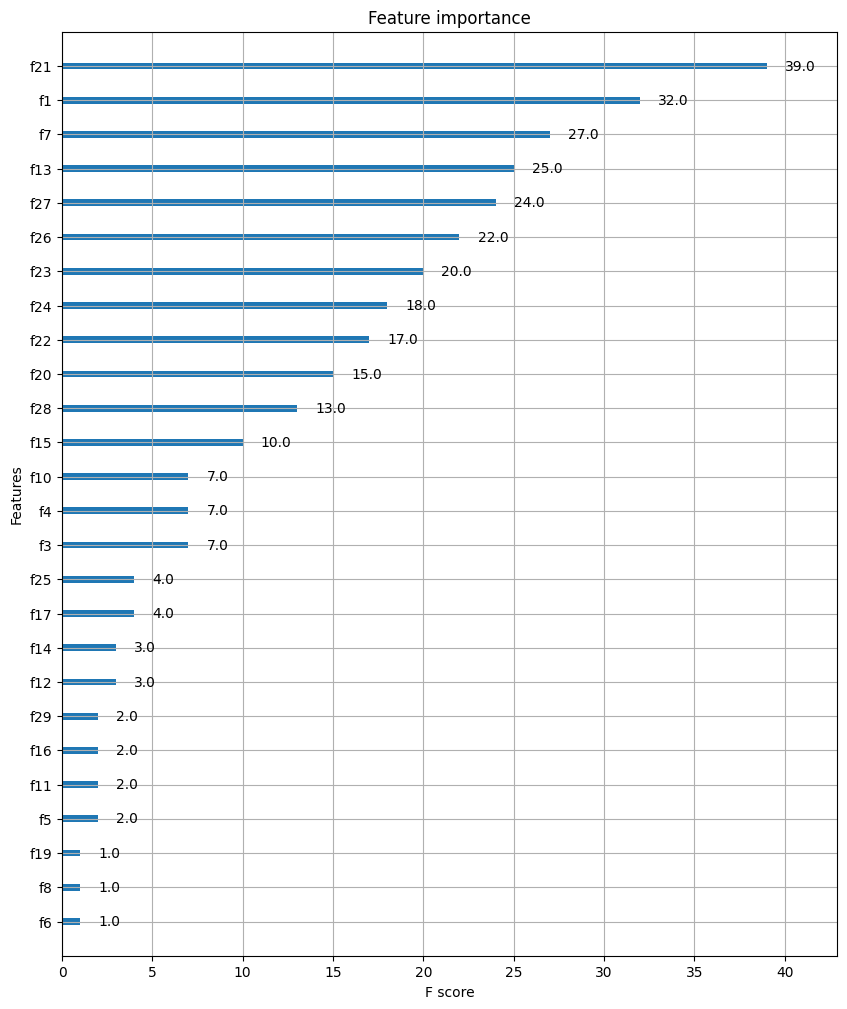

In [43]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (10, 12))
#사이킷런 Wrapper 클래스를 입력해도 무방
plot_importance(xgb_wrapper, ax=ax)

**[XGBoost]**  
- 사이킷런 래퍼 클래스와 파이썬 래퍼 클래스 두 가지로 구현 가능.  
- GBM 대비 빠른 수행 시간
- 뛰어난 예측 성능
- 과적합 규제 가능
 - `learning_rate` ⬇️
 - `max_depth` ⬇️
 - `min_child_weight` ⬆️
 - `gamma` ⬆️
- 불필요한 분할 줄이는 가지치기 가능
- 자체 내장된 교차 검증
- 결손값 자체 처리

- `XGBClassifier` (사이킷런 래퍼 기반 작성)
 - `learning_rate` : 학습률
 - `subsample`
 - `reg_lambda` : L2 규제 적용 값
 - `reg_alpha` : L1 규제 적용 값
 - `n_estimators`
 - `colsample_bytree` : 트리 생성에 필요한 피처를 임의로 샘플링
 - `early_stopping_rounds` : 일정 반복 동안 성능 향상이 없으면 멈춤
 - `min_child_weight` : 트리에서 추가적으로 가지를 나눌지 결정하기 위해 사용. 클수록 분할이 자제되어 과적합 제어 가능